# Space-time visualisations (giddy)

In [26]:
import libpysal.api as lp
from libpysal import examples
import libpysal.io.geotable as pdio
import numpy as np
import pandas as pd
import geopandas as gpd
from giddy.directional import Rose
import matplotlib.pyplot as plt
from splot import plot
import esda
from splot.bk import lisa_cluster
from bokeh.io import show
import seaborn as sns
from splot.mpl import lisa_cluster
from splot._viz_utils import moran_hot_cold_spots, mask_local_auto
from splot._viz_bokeh import _lisa_cluster_fig

from ipywidgets import interact, fixed
import ipywidgets as widgets

%matplotlib inline

# Data preparation

In [2]:
# get csv and shp and merge
shp_link = examples.get_path('us48.shp')
df = gpd.read_file(shp_link)
income_table = pd.read_csv(examples.get_path("usjoin.csv"))

In [3]:
# calculate relative values
for year in range(1969, 2010):
    income_table[str(year) + '_rel'] = income_table[str(year)] / income_table[str(year)].mean()

In [4]:
# merge
gdf = df.merge(income_table,left_on='STATE_NAME',right_on='Name')

In [41]:
#calculate weights and moran_loc
w = lp.Queen.from_dataframe(gdf)
w.transform = 'r'
y4 = gdf['1969_rel'].values
y5 = gdf['2000_rel'].values
#moran_loc1 = esda.moran.Moran_Local(y1, w)
#moran_loc2 = esda.moran.Moran_Local(y2,w)

(48, 2)


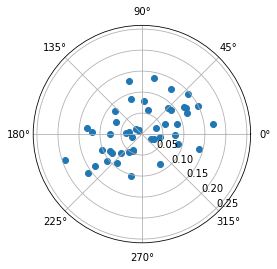

In [44]:
Y = np.array([y4, y5]).T
print(Y.shape)

rose = Rose(Y, w, k=5)
rose.plot()

# Plotting

## Utility Functions

In [5]:
def _space_time_gdf_calc(gdf, timex, timey):
    #calculate data for plotting:
    w = lp.Queen.from_dataframe(gdf)
    w.transform = 'r'
    y1 = gdf[timex].values
    y2 = gdf[timey].values
    
    #keep the same state
    old_state = np.random.get_state()
    moran_loc1 = esda.moran.Moran_Local(y1, w)
    np.random.set_state(old_state)
    moran_loc2 = esda.moran.Moran_Local(y2, w)
    np.random.set_state(old_state)
    
    return y1, y2, moran_loc1, moran_loc2

In [6]:
def _space_time_heatmap_data(moran_loc1, moran_loc2, p=0.05):
    cluster = moran_hot_cold_spots(moran_loc1, p=p)
    cluster2 = moran_hot_cold_spots(moran_loc2, p=p)

    # to put into seaborn function
    # and set diagonal elements to zero to see the rest better
    heatmap_data = np.zeros((5, 5), dtype=int)
    mask = np.zeros((5, 5), dtype=bool)
    for row in range(5):
        for col in range(5):
            yr1 = cluster == row
            yr2 = cluster2 == col
            heatmap_data[row, col] = (yr1 & yr2).sum()
            if row == col:
                mask[row, col] = True
                
    return heatmap_data, mask

# MPL

## Heatmap

In [7]:
def space_time_heatmap(moran_loc1, moran_loc2, p=0.05, ax=None): # y1, y2, 
    heatmap_data, mask = _space_time_heatmap_data(moran_loc1, moran_loc2, p=p)

    # set name for tick labels
    xticklabels = ['ns', 'HH', 'HL', 'LH', 'LL'] 
    yticklabels = ['ns', 'HH', 'HL', 'LH', 'LL']  

    fig = sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu",
                xticklabels=xticklabels, yticklabels=yticklabels,
                mask=mask, center=20, ax=ax, cbar=False, square=True)
    return fig

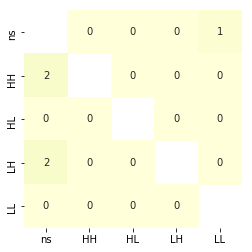

In [11]:
moran_loc1 = esda.moran.Moran_Local(y4, w)
moran_loc2 = esda.moran.Moran_Local(y5,w)
space_time_heatmap(moran_loc1=moran_loc1, moran_loc2=moran_loc2)
plt.show()

## static space time autocorrelation

In [12]:
def space_time_correl(gdf, timex, timey,
                      p=0.05, figsize=(13,10)):
    
    y1, y2, moran_loc1, moran_loc2 = _space_time_gdf_calc(gdf=gdf, timex=timex, timey=timey)

    fig = plt.figure(figsize=figsize)
    fig.suptitle('Space-time autocorrelation', fontsize=20)
    axs = []
    axs.append(plt.subplot(221))
    axs.append(plt.subplot(222))
    axs.append(plt.subplot(223, projection='polar'))
    axs.append(plt.subplot(224))
    
    # space_time_heatmap
    fig = space_time_heatmap(moran_loc1, moran_loc2, p=p, ax=axs[0])
    fig.xaxis.set_ticks_position('top')
    fig.set_xlabel(timex)
    fig.xaxis.set_label_position('top')
    fig.set_ylabel(timey)

    # Lisa_clusters
    lisa_cluster(moran_loc1, gdf, p=p, ax=axs[1], legend=True,
                 legend_kwds={'loc': 'upper left',
                 'bbox_to_anchor': (0.92, 1.05)})
    lisa_cluster(moran_loc2, gdf, p=p, ax=axs[3], legend=True,
                 legend_kwds={'loc': 'upper left',
                 'bbox_to_anchor': (0.92, 1.05)})

    # Rose diagram: Moran movement vectors:
    Y = np.array([y1, y2]).T
    print(Y.shape)

    rose = Rose(Y, w, k=5)
    rose.plot(ax=axs[2])
    #rose.plot(attribute=Y[:,0], ax=axs[2]) # colorbar placement is messed up
    
    return fig

(48, 2)


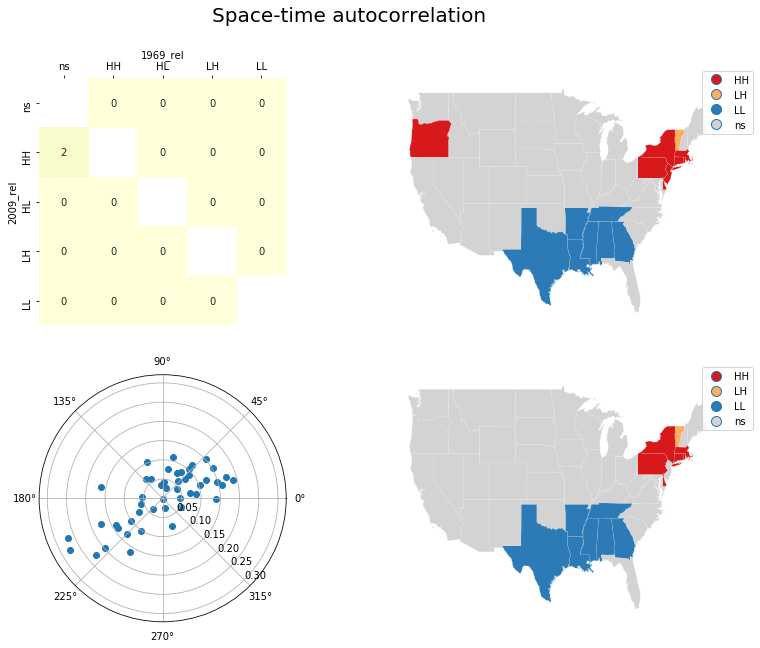

In [13]:
space_time_correl(gdf, timex='1969_rel', timey='2009_rel')
plt.show()

## Interactive space time autocorrelation

In [14]:
def space_time_correl_interactive(gdf, pattern='_rel', p=0.05, figsize=(13,10)):    
    coldict = {col: col for col in gdf.columns if col.endswith(pattern)}
    interact(space_time_correl,
             timex=coldict, timey=coldict, gdf=fixed(gdf), p=fixed(p), figsize=fixed(figsize))

# Bokeh

In [22]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LinearColorMapper, GeoJSONDataSource
from bokeh.sampledata.les_mis import data
from bokeh.palettes import Viridis256, Greys256, Magma256, linear_palette, YlGnBu9

output_notebook()

def heatmap_lisa(gdf, timex, timey, p=0.05):
    # retrieve LISA counts
    y1, y2, moran_loc1, moran_loc2 = _space_time_gdf_calc(gdf=gdf, timex=timex, timey=timey)
    counts, _ = _space_time_heatmap_data(moran_loc1=moran_loc1, moran_loc2=moran_loc2, p=p)
    names = ['ns', 'HH', 'HL', 'LH', 'LL']
    
    # data for labels and colors
    xname = []
    yname = []
    color = []
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            xname.append(name1)
            yname.append(name2)
            if i == j:
                # mask the diagonal at a lighter color
                color.append(-2)
            else:
                color.append(counts[i, j])
            
    Magma256.reverse()
    mapper = LinearColorMapper(palette=Magma256, low=-2, high=counts.max())
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    
    # create ColumnDataSource
    source = ColumnDataSource(data=dict(
        xname=xname,
        yname=yname,
        colors=color,
        count=counts.flatten(),
    ))

    fig = figure(title="Space Time LISA Heatmap",
           x_axis_location="above", tools="hover,save",
           x_range=names, y_range=list(reversed(names)))

    fig.plot_width = 300
    fig.plot_height = 300
    fig.grid.grid_line_color = None
    fig.axis.axis_line_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.major_label_text_font_size = "8pt"
    fig.axis.major_label_standoff = 0
    fig.xaxis.major_label_orientation = np.pi/3

    fig.rect('xname', 'yname', 0.99, 0.99, source=source,
           fill_color={'field': 'colors', 'transform': mapper},
           line_color=None,
           hover_line_color='black', hover_color={'field': 'colors', 'transform': mapper})

    fig.select_one(HoverTool).tooltips = [
        ('names', '@yname, @xname'),
        ('count', '@count'),
    ]

    #p.add_layout(color_bar, 'right')
    return fig

Loading BokehJS ...

In [23]:
p = heatmap_lisa(gdf, timex='1969_rel', timey='2009_rel')
show(p)

In [29]:
def space_time_correll_bk(gdf, timex, timey, p=0.05):
    # We're adding columns, do that on a copy rather than on the users' input
    gdf = gdf.copy()
    
    _, _, moran_locx, moran_locy = _space_time_gdf_calc(gdf=gdf, timex=timex, timey=timey)

    # add cluster_labels and colors5 in mask_local_auto
    cluster_labels, colors5, _, labels = mask_local_auto(moran_locx, p=0.05)
    gdf['labels_lisa2'] = labels
    gdf['moranlocx_psim'] = moran_locx.p_sim
    gdf['moranlocx_q'] = moran_locx.q
    
    # add cluster_labels and colors5 in mask_local_auto
    cluster_labels, colors5, _, labels = mask_local_auto(moran_locy, p=0.05)
    gdf['labels_lisa2'] = labels
    gdf['moranlocy_psim'] = moran_locy.p_sim
    gdf['moranlocy_q'] = moran_locy.q
    

    # load df into bokeh data source
    geo_source = GeoJSONDataSource(geojson=gdf.to_json())

    TOOLS = "tap,reset,help,hover"
    region_column= ''
    
    heatmap = heatmap_lisa(gdf, timex=timex, timey=timey)
    LISA1 = _lisa_cluster_fig(geo_source, moran_locx, cluster_labels, colors5,
                             bounds=df.total_bounds,
                             region_column=region_column,
                             plot_width=plot_width,
                             plot_height=plot_height, tools=TOOLS)
    LISA2 = _lisa_cluster_fig(geo_source, moran_locy, cluster_labels, colors5,
                             bounds=df.total_bounds,
                             region_column=region_column,
                             plot_width=plot_width,
                             plot_height=plot_height, tools=TOOLS)
    
    fig = gridplot([[heatmap, LISA1, LISA2]],
                   sizing_mode='scale_width')
    return fig

In [30]:
fig = space_time_correll_bk(gdf, '1969_rel', '2009_rel', p=0.05)
show(fig)

NameError: name 'plot_width' is not defined

def space_time_correl_interactive(gdf, pattern='_rel', p=0.05, figsize=(13,10)):    
    coldict = {col: col for col in gdf.columns if col.endswith(pattern)}
    interact(heatmap_lisa,
             timex=coldict, timey=coldict, gdf=fixed(gdf), p=fixed(p), figsize=fixed(figsize))
    fig.data_source.data
    push_notebook()

from bokeh.io import push_notebook

space_time_correl_interactive(gdf, '_rel')


fig, update_heatmap = heatmap_lisa(gdf, timex='1969_rel', timey='2009_rel')

coldict = {col: col for col in gdf.columns if col.endswith(pattern)}
interact(update_heatmap,
         timex=coldict, timey=coldict, gdf=fixed(gdf), p=fixed(p), figsize=fixed(figsize))
    
handle = show(fig, notebook_handle=True)

## IDEAS

In [15]:
def moran_loc_gdf(timex, timey, gdf):
    #wrapper function of interactive autocorrelation
    '''w = lp.Queen.from_dataframe(gdf)
    w.transform = 'r'
    y1 = gdf[str(timex)].values
    y2 = gdf[str(timey)].values
    # Moran_Local uses random numbers, which we cannot change between the two years!
    old_state = np.random.get_state()
    moran_loc1 = esda.moran.Moran_Local(y1, w)
    np.random.set_state(old_state)
    moran_loc2 = esda.moran.Moran_Local(y2, w)
    np.random.set_state(old_state)'''
    space_time_autocorrelation(gdf=gdf, timex=timex, timey=timey)

In [16]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.sampledata.les_mis import data
from bokeh.palettes import Viridis256, Greys256, Magma256, linear_palette, YlGnBu9

from bokeh.io import curdoc
from bokeh.layouts import row, widgetbox
from bokeh.models.widgets import Slider, TextInput

output_notebook()

def prep_datasource(gdf, timex, timey, p=0.05):
    # retrieve LISA counts from _space_time_data_clac
    counts = _space_time_gdf_calc(gdf, timex, timey, p=p)
    names = ['ns', 'HH', 'HL', 'LH', 'LL']

    # data for labels and colors
    xname = []
    yname = []
    color = []
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            xname.append(name1)
            yname.append(name2)
            if i == j:
                # mask the diagonal at a lighter color
                color.append(-2)
            else:
                color.append(counts[i, j])

    datacols = dict(xname=xname, yname=yname, colors=color, count=counts.flatten())
    return names, datacols

def heatmap_lisa_slider(gdf, timex, timey, p=0.05):
    
    # create ColumnDataSource
    names, datacols = prep_datasource(gdf=gdf, timex=timex, timey=timey, p=p)
    source = ColumnDataSource(data=datacols)

    Magma256.reverse()
    mapper = LinearColorMapper(palette=Magma256, low=-2, high=datacols['count'].max())
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    
    fig = figure(title="Space Time LISA Heatmap",
           x_axis_location="above", tools="hover,save",
           x_range=names, y_range=list(reversed(names)))

    fig.plot_width = 300
    fig.plot_height = 300
    fig.grid.grid_line_color = None
    fig.axis.axis_line_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.major_label_text_font_size = "8pt"
    fig.axis.major_label_standoff = 0
    fig.xaxis.major_label_orientation = np.pi/3

    heatmap_rects = fig.rect('xname', 'yname', 0.99, 0.99, source=source,
           fill_color={'field': 'colors', 'transform': mapper},
           line_color=None,
           hover_line_color='black', hover_color={'field': 'colors', 'transform': mapper})

    fig.select_one(HoverTool).tooltips = [
        ('names', '@yname, @xname'),
        ('count', '@count'),
    ]

    #year1_slider = Slider(title="Start year", value=1969, start=1969, end=2009, step=1)
    #def update_year1(newyear):
    #    datacols = prep_datasource(str(newyear) + '_rel', timey)
    #    source.data = datacols

    return fig#, heatmap_rects

Loading BokehJS ...

In [17]:
p = heatmap_lisa_slider(gdf, timex='1969_rel', timey='2009_rel')
show(p, notebook_handle=True)

In [18]:
#def space_time_correl_interactive(gdf, pattern='_rel', p=0.05, figsize=(13,10)):  

def update():
    _, datacols = prep_datasource(gdf=gdf, timex=timex, timey=timey, p=p)
    push_notebook()
    
    
coldict = {col: col for col in gdf.columns if col.endswith(pattern)}
interact(prep_datasource,
         timex=coldict, timey=coldict, gdf=fixed(gdf), p=fixed(p), figsize=fixed(figsize))

NameError: name 'pattern' is not defined

In [ ]:
#from bokeh.io import push_notebook

#space_time_correl_interactive(gdf, '_rel')

In [ ]:
p.references()